# S12 Intraday Options Evaluation Harness v2

**Audit-grade** walk-forward evaluation of regime-conditional option strategies.

**Key properties:**
- Zero look-ahead: features at minute t use only data ≤ t; SANOS regime from previous day's EOD
- Training label = actual spread payoff sign (not underlying return)
- SANOS/fractional regime gating: vol cheap → debit, vol rich → credit, neutral → debit
- Adverse execution: close-as-mid + parametric spread ticks
- Liquidity gates: OI, volume, price minimums
- Cost sensitivity sweep: ticks × fees grid
- Feature ablation stability: 6 groups including SANOS + fractional
- Regime-conditioned structures: debit spreads vs credit spreads

**Data**: 316 days of 1-min OHLCV (nfo_1min), daily index close, no bid/ask.

In [1]:
"""Cell 1: Imports & DuckDB connection."""
import sys, os
sys.path.insert(0, "/home/ubuntu/Desktop/7hills/QuantLaxmi")

import duckdb
import numpy as np
import pandas as pd
import math
import time
import warnings
from dataclasses import dataclass, field
from typing import Dict, List, Tuple, Optional
from datetime import datetime, timedelta
from functools import lru_cache

from core.pricing.sanos import fit_sanos
from core.pricing.risk_neutral import (
    extract_density, compute_moments, shannon_entropy, kl_divergence, tail_weights,
)

warnings.filterwarnings("ignore", category=FutureWarning)

DATA_BASE = "/home/ubuntu/Desktop/7hills/QuantLaxmi/data/market"
con = duckdb.connect()

# nfo_1min: option + futures tick data
con.execute(f"""
    CREATE OR REPLACE VIEW nfo_1min AS
    SELECT * FROM read_parquet(
        '{DATA_BASE}/nfo_1min/*/*.parquet',
        hive_partitioning=true, union_by_name=true)
""")

# nse_index_close: daily index values (needed for SANOS spot)
con.execute(f"""
    CREATE OR REPLACE VIEW nse_index_close AS
    SELECT * FROM read_parquet(
        '{DATA_BASE}/nse_index_close/*/*.parquet',
        hive_partitioning=true, hive_types_autocast=false, union_by_name=true)
""")

# Verify
row_count = con.execute("SELECT COUNT(*) FROM nfo_1min").fetchone()[0]
day_count = con.execute("SELECT COUNT(DISTINCT date) FROM nfo_1min").fetchone()[0]
idx_count = con.execute("SELECT COUNT(DISTINCT date) FROM nse_index_close").fetchone()[0]
print(f"nfo_1min: {row_count:,} rows, {day_count} days")
print(f"nse_index_close: {idx_count} days")

nfo_1min: 169,402,407 rows, 316 days
nse_index_close: 125 days


In [2]:
"""Cell 2: Session constants and configuration."""

SESSION_START = "09:15:00"
SESSION_MINUTES = 375       # 09:15..15:29
STRIKE_STEP = {"NIFTY": 50, "BANKNIFTY": 100}
INDEX_NAME_MAP = {"NIFTY": "Nifty 50", "BANKNIFTY": "Nifty Bank"}
NAME = "NIFTY"

# Walk-forward config
TRAIN_DAYS = 60
TEST_DAYS = 10
DECISION_STEP = 5           # minutes between candidate entries
ENTRY_MIN = 15              # 09:30 (15 min after open)
EXIT_MIN = 330              # 14:45
HOLD_MIN = 60               # 60-minute time stop
SCORE_THRESHOLD = 0.5       # |score| must exceed this to trade
WING_STEPS = 1              # OTM offset for short leg

# Liquidity gates
OI_MIN = 500
VOL_MIN = 10
PRICE_MIN = 2.0

# Cost sensitivity grid: (spread_ticks, fees_bps)
COST_GRID = [
    (1, 10.0), (2, 10.0), (3, 10.0),
    (1, 20.0), (2, 20.0), (3, 20.0),
    (5, 20.0), (8, 40.0),
]
TICK_SIZE = 0.05

# ── SANOS regime thresholds ──
# Entropy < threshold → vol cheap (subdiffusive, buy vol → debit spreads)
# Entropy > threshold → vol rich (superdiffusive, sell vol → credit spreads)
ENTROPY_LOW = 3.5      # below → vol cheap
ENTROPY_HIGH = 4.5     # above → vol rich
ALPHA_SUBDIFFUSIVE = 1.8   # α < this → subdiffusive (mean-reverting)
ALPHA_SUPERDIFFUSIVE = 2.2 # α > this → superdiffusive (trending)

# Feature groups for ablation
FEATURE_GROUPS = {
    "momentum":  {"mom_5", "mom_15", "mom_30"},
    "volatility": {"rv_30", "rv_120", "range_ratio"},
    "trend":     {"slope_60", "slope_120"},
    "volume":    {"vol_ratio", "oi_change_rate"},
    "sanos":     {"sanos_skew", "sanos_entropy", "sanos_kl", "sanos_left_tail"},
    "fractional": {"frac_alpha", "frac_rvd"},
}

# Ablation scenarios
ABLATIONS = [
    [],                          # baseline (all features)
    ["momentum"],
    ["volatility"],
    ["trend"],
    ["volume"],
    ["sanos"],
    ["fractional"],
    ["sanos", "fractional"],
    ["momentum", "trend"],
]

print(f"Config: {NAME}, train={TRAIN_DAYS}d, test={TEST_DAYS}d, "
      f"hold={HOLD_MIN}m, step={DECISION_STEP}m")
print(f"Cost grid: {len(COST_GRID)} scenarios, Ablations: {len(ABLATIONS)} scenarios")
print(f"Total evaluation runs: {len(COST_GRID) * len(ABLATIONS)}")

Config: NIFTY, train=60d, test=10d, hold=60m, step=5m
Cost grid: 8 scenarios, Ablations: 9 scenarios
Total evaluation runs: 72


In [3]:
"""Cell 3: Data access helpers — ALL option chain data preloaded into memory.

Key optimization: load all option bars for each day into RAM once,
then all chain_at_minute / contract_at_minute calls are dict lookups.
This avoids 20K+ DuckDB queries during label precomputation and walk-forward.
"""

def list_trading_days(con, name: str) -> List[str]:
    df = con.execute("""
        SELECT DISTINCT CAST(date AS VARCHAR) AS d
        FROM nfo_1min WHERE name = ? ORDER BY d
    """, [name]).fetchdf()
    return df["d"].tolist()


def nearest_expiry(con, name: str, date_str: str, instrument_type: str) -> Optional[str]:
    df = con.execute("""
        SELECT CAST(MIN(expiry) AS VARCHAR) AS e
        FROM nfo_1min
        WHERE name = ? AND date = ? AND instrument_type = ?
    """, [name, date_str, instrument_type]).fetchdf()
    e = df.loc[0, "e"] if len(df) and df.loc[0, "e"] is not None else None
    return e


def fut_close_series(con, name: str, date_str: str) -> Optional[pd.DataFrame]:
    """All 1-min bars for nearest-expiry futures on a day, ordered by time."""
    e = nearest_expiry(con, name, date_str, "FUT")
    if not e:
        return None
    df = con.execute("""
        SELECT open, high, low, close, volume, oi
        FROM nfo_1min
        WHERE name = ? AND date = ? AND instrument_type = 'FUT' AND expiry = ?
    """, [name, date_str, e]).fetchdf()
    if df.empty or len(df) < 30:
        return None
    return df.reset_index(drop=True)


# ── Preload ALL option chain data into memory ──

def preload_option_chains(con, name, days):
    """Load all CE/PE option bars for nearest expiry into memory.

    Returns:
      chain_mem[day][right] = {strike: {"symbol": str, "close": np.array,
                                         "volume": np.array, "oi": np.array}}
      expiry_mem[day][right] = expiry string
    """
    chain_mem = {}
    expiry_mem = {}
    t0 = time.time()

    for i, d in enumerate(days):
        chain_mem[d] = {}
        expiry_mem[d] = {}
        for right in ["CE", "PE"]:
            exp = nearest_expiry(con, name, d, right)
            if not exp:
                continue
            expiry_mem[d][right] = exp

            df = con.execute("""
                SELECT strike, symbol, close, volume, oi
                FROM nfo_1min
                WHERE name = ? AND date = ? AND instrument_type = ? AND expiry = ?
                ORDER BY strike
            """, [name, d, right, exp]).fetchdf()

            if df.empty:
                continue

            strikes = {}
            for strike, grp in df.groupby("strike"):
                strikes[float(strike)] = {
                    "symbol": str(grp["symbol"].iloc[0]),
                    "close": grp["close"].values.astype(np.float64),
                    "volume": grp["volume"].values.astype(np.int64),
                    "oi": grp["oi"].values.astype(np.int64),
                }
            chain_mem[d][right] = strikes

        if (i + 1) % 50 == 0:
            print(f"  Preloaded {i+1}/{len(days)} days ({time.time()-t0:.0f}s)", flush=True)

    print(f"  Chain preload DONE: {len(chain_mem)} days in {time.time()-t0:.0f}s")
    return chain_mem, expiry_mem


# ── In-memory chain access ──

def chain_at_minute_mem(chain_mem, day, right, minute_offset):
    """Get chain snapshot at a specific minute from preloaded data.
    Returns DataFrame with columns: strike, close, volume, oi, symbol.
    """
    if day not in chain_mem or right not in chain_mem[day]:
        return pd.DataFrame()
    strikes = chain_mem[day][right]
    rows = []
    for k, data in strikes.items():
        idx = int(minute_offset)
        if idx >= len(data["close"]):
            continue
        rows.append({
            "strike": k,
            "close": float(data["close"][idx]),
            "volume": int(data["volume"][idx]),
            "oi": int(data["oi"][idx]),
            "symbol": data["symbol"],
        })
    if not rows:
        return pd.DataFrame()
    return pd.DataFrame(rows).sort_values("strike").reset_index(drop=True)


def contract_at_minute_mem(chain_mem, day, symbol, minute_offset):
    """Get single contract bar from preloaded data."""
    if day not in chain_mem:
        return None
    for right in ["CE", "PE"]:
        if right not in chain_mem[day]:
            continue
        for k, data in chain_mem[day][right].items():
            if data["symbol"] == symbol:
                idx = int(minute_offset)
                if idx >= len(data["close"]):
                    return None
                return {
                    "close": float(data["close"][idx]),
                    "volume": int(data["volume"][idx]),
                    "oi": int(data["oi"][idx]),
                }
    return None


# ── Execute preload ──
days = list_trading_days(con, NAME)
print(f"Trading days: {len(days)} ({days[0]} -> {days[-1]})")

print("Preloading option chain data into memory...")
chain_mem, expiry_mem = preload_option_chains(con, NAME, days)

sample_fut = fut_close_series(con, NAME, days[-1])
print(f"Sample futures bars ({days[-1]}): {len(sample_fut)} bars")

Trading days: 316 (2024-10-29 -> 2026-02-06)
Preloading option chain data into memory...


  Preloaded 50/316 days (7s)


  Preloaded 100/316 days (13s)


  Preloaded 150/316 days (20s)


  Preloaded 200/316 days (26s)


  Preloaded 250/316 days (32s)


  Preloaded 300/316 days (39s)


  Chain preload DONE: 316 days in 41s
Sample futures bars (2026-02-06): 375 bars


In [4]:
"""Cell 3b: SANOS + fractional regime precomputation.

For each day, calibrate SANOS from PREVIOUS day's EOD option chain (causal).
Compute fractional diffusion exponent from cumulative daily returns.
Build regime cache: dict[date] -> {sanos features, alpha, regime_class}.

regime_class:
  "vol_cheap"  → low entropy + subdiffusive → BUY vol → debit spreads
  "vol_rich"   → high entropy + superdiffusive → SELL vol → credit spreads
  "neutral"    → ambiguous → debit spreads (safer default)
"""

# ── Fractional diffusion estimators ──

def estimate_alpha_msd(returns, max_lag=50):
    """MSD scaling: MSD(τ) ~ τ^{2H}, α = 2H."""
    cumret = np.cumsum(returns)
    n = len(cumret)
    max_lag = min(max_lag, n // 3)
    if max_lag < 4:
        return 1.0
    lags = np.arange(2, max_lag + 1)
    msds = np.empty(len(lags))
    for i, tau in enumerate(lags):
        displacements = cumret[tau:] - cumret[:-tau]
        msds[i] = np.mean(displacements**2)
    valid = msds > 0
    if valid.sum() < 3:
        return 1.0
    log_lags = np.log(lags[valid])
    log_msds = np.log(msds[valid])
    slope, _ = np.polyfit(log_lags, log_msds, 1)
    hurst = np.clip(slope / 2.0, 0.01, 1.5)
    return float(2.0 * hurst)


def estimate_alpha_waiting(returns, threshold=0.0):
    """Hill estimator from waiting-time distribution."""
    if threshold <= 0:
        threshold = np.std(returns, ddof=1) * 0.5 if len(returns) > 2 else 1e-8
    exceedance_idx = np.where(np.abs(returns) > threshold)[0]
    if len(exceedance_idx) < 10:
        return 1.0
    waiting_times = np.diff(exceedance_idx).astype(float)
    waiting_times = waiting_times[waiting_times > 0]
    if len(waiting_times) < 5:
        return 1.0
    sorted_wt = np.sort(waiting_times)[::-1]
    k = max(int(len(sorted_wt) * 0.1), 5)
    k = min(k, len(sorted_wt) - 1)
    log_ratios = np.log(sorted_wt[:k]) - np.log(sorted_wt[k])
    if np.sum(log_ratios) == 0:
        return 1.0
    return float(np.clip(k / np.sum(log_ratios), 0.1, 3.0))


def estimate_alpha(returns, max_lag=50):
    """Consensus: 0.6 × MSD + 0.4 × waiting-time."""
    return 0.6 * estimate_alpha_msd(returns, max_lag) + 0.4 * estimate_alpha_waiting(returns)


def ramanujan_volatility_distortion(vol, alpha=0.2, depth=20):
    """Continued-fraction volatility transform R(V)."""
    cf = 1.0
    for k in range(depth, 0, -1):
        cf = 1.0 + k * vol / max(cf, 1e-30)
    return math.exp(-alpha * vol) / max(cf, 1e-30)


# ── SANOS chain builder from 1-min data ──

def prepare_chain_from_1min(con, symbol, d, max_expiries=2):
    """Build SANOS-ready option chain from nfo_1min last-bar snapshot."""
    df = con.execute("""
        SELECT strike, instrument_type, expiry,
               LAST(close) AS close, LAST(oi) AS oi
        FROM nfo_1min
        WHERE date = ? AND name = ? AND instrument_type IN ('CE', 'PE')
        GROUP BY strike, instrument_type, expiry
        ORDER BY expiry, strike
    """, [d, symbol]).fetchdf()

    if df is None or len(df) < 20:
        return None

    # Spot from index close or futures fallback
    idx_name = INDEX_NAME_MAP.get(symbol, symbol)
    try:
        spot_df = con.execute(
            'SELECT "Closing Index Value" AS spot FROM nse_index_close '
            'WHERE "Index Name" = ? AND date = ?', [idx_name, d]
        ).fetchdf()
        if not spot_df.empty and spot_df["spot"].iloc[0] is not None:
            spot = float(spot_df["spot"].iloc[0])
        else:
            fut_df = con.execute(
                "SELECT LAST(close) AS c FROM nfo_1min "
                "WHERE name = ? AND date = ? AND instrument_type = 'FUT' "
                "AND expiry = (SELECT MIN(expiry) FROM nfo_1min "
                "WHERE name = ? AND date = ? AND instrument_type = 'FUT')",
                [symbol, d, symbol, d]
            ).fetchdf()
            if fut_df.empty:
                return None
            spot = float(fut_df["c"].iloc[0])
    except Exception:
        return None

    expiries = sorted(df["expiry"].unique())[:max_expiries]
    market_strikes_list, market_calls_list, atm_vars, expiry_labels = [], [], [], []

    for exp in expiries:
        sub = df[df["expiry"] == exp].copy()
        calls = sub[sub["instrument_type"] == "CE"].set_index("strike")["close"]
        puts = sub[sub["instrument_type"] == "PE"].set_index("strike")["close"]
        common = sorted(set(calls.index) & set(puts.index))
        if len(common) < 10:
            continue

        best_F, best_diff = spot, float("inf")
        for K in common:
            C, P = float(calls[K]), float(puts[K])
            if C <= 0 or P <= 0:
                continue
            F = K + C - P
            diff = abs(C - P)
            if diff < best_diff:
                best_diff = diff
                best_F = F
        forward = best_F

        rows = []
        for K in common:
            C_val, P_val = float(calls[K]), float(puts[K])
            k_norm = K / forward
            if K >= forward:
                c_norm = C_val / forward
                if c_norm > 0.001:
                    rows.append((k_norm, c_norm))
            else:
                c_norm = P_val / forward + 1.0 - k_norm
                if c_norm > 0.001:
                    rows.append((k_norm, c_norm))

        if len(rows) < 5:
            continue
        rows.sort(key=lambda x: x[0])
        k_arr = np.array([r[0] for r in rows])
        c_arr = np.array([r[1] for r in rows])

        atm_K = min(common, key=lambda K: abs(K - forward))
        straddle = float(calls[atm_K]) + float(puts[atm_K])
        straddle_norm = straddle / forward
        atm_var = max((straddle_norm / 2.0 * math.sqrt(2.0 * math.pi)) ** 2, 1e-6)

        market_strikes_list.append(k_arr)
        market_calls_list.append(c_arr)
        atm_vars.append(atm_var)
        expiry_labels.append(str(exp))

    if not market_strikes_list:
        return None
    return {
        "market_strikes": market_strikes_list,
        "market_calls": market_calls_list,
        "atm_variances": np.array(atm_vars),
        "expiry_labels": expiry_labels,
        "forward": forward,
        "spot": spot,
    }


# ── Calibrate SANOS for all dates ──

def calibrate_sanos_daily(con, symbol, dates):
    """SANOS calibration per date. Returns dict[date] -> features."""
    cache = {}
    prev_density, prev_K = None, None
    ok_count, fail_count = 0, 0
    t0 = time.time()

    for i, d in enumerate(dates):
        chain = prepare_chain_from_1min(con, symbol, d, max_expiries=2)
        if chain is None:
            fail_count += 1
            continue
        try:
            result = fit_sanos(
                market_strikes=chain["market_strikes"],
                market_calls=chain["market_calls"],
                atm_variances=chain["atm_variances"],
                expiry_labels=chain["expiry_labels"],
                eta=0.50, n_model_strikes=80,
            )
        except Exception:
            fail_count += 1
            continue
        if not result.lp_success:
            fail_count += 1
            continue

        K, q = extract_density(result, 0)
        dK = K[1] - K[0]
        mu, var, skew, kurt = compute_moments(K, q)
        std = math.sqrt(max(var, 1e-14))
        H = shannon_entropy(q, dK)
        lt, rt = tail_weights(K, q, mu, std)

        kl = 0.0
        if prev_density is not None and prev_K is not None:
            prev_q_interp = np.interp(K, prev_K, prev_density)
            prev_q_interp = np.maximum(prev_q_interp, 0)
            total_prev = np.sum(prev_q_interp) * dK
            if total_prev > 1e-12:
                prev_q_interp /= total_prev
            kl = kl_divergence(q, prev_q_interp, dK)

        cache[d] = {
            "skew": skew, "kurtosis": kurt,
            "left_tail": lt, "right_tail": rt,
            "entropy": H, "kl": kl,
            "forward": chain["forward"],
        }
        prev_density, prev_K = q, K
        ok_count += 1

        if (i + 1) % 50 == 0:
            print(f"  SANOS {i+1}/{len(dates)}: {ok_count} ok, {fail_count} fail "
                  f"({time.time()-t0:.0f}s)")

    print(f"  SANOS DONE: {ok_count}/{len(dates)} calibrated in {time.time()-t0:.0f}s")
    return cache


# ── Build regime cache ──

def build_regime_cache(sanos_cache, daily_closes, days):
    """Combine SANOS + fractional alpha into regime classification per day.

    CAUSAL: regime for day i uses SANOS from day i-1 (EOD chain)
    and fractional alpha from daily returns up to day i-1.
    """
    regime_cache = {}

    # Daily log returns for fractional alpha
    daily_rets = []
    for i, d in enumerate(days):
        if i == 0:
            daily_rets.append(0.0)
            continue
        c_prev = daily_closes.get(days[i-1])
        c_curr = daily_closes.get(d)
        if c_prev and c_curr and c_prev > 0 and c_curr > 0:
            daily_rets.append(math.log(c_curr / c_prev))
        else:
            daily_rets.append(0.0)

    for i, d in enumerate(days):
        prev_d = days[i-1] if i > 0 else None

        # SANOS features from previous day (causal)
        sanos = sanos_cache.get(prev_d, {}) if prev_d else {}
        entropy = sanos.get("entropy", float("nan"))
        skew = sanos.get("skew", 0.0)
        kl = sanos.get("kl", 0.0)
        left_tail = sanos.get("left_tail", 0.0)

        # Fractional alpha from returns up to previous day
        rets_so_far = np.array(daily_rets[1:i] if i > 1 else [0.0])
        alpha = estimate_alpha(rets_so_far) if len(rets_so_far) >= 20 else 2.0
        rv = np.std(rets_so_far[-30:], ddof=1) if len(rets_so_far) >= 30 else 0.0
        rvd = ramanujan_volatility_distortion(rv) if rv > 0 else 0.5

        # Regime classification
        if np.isfinite(entropy) and entropy < ENTROPY_LOW and alpha < ALPHA_SUBDIFFUSIVE:
            regime_class = "vol_cheap"   # debit spreads
        elif np.isfinite(entropy) and entropy > ENTROPY_HIGH and alpha > ALPHA_SUPERDIFFUSIVE:
            regime_class = "vol_rich"    # credit spreads
        else:
            regime_class = "neutral"     # default debit

        regime_cache[d] = {
            "sanos_skew": skew,
            "sanos_entropy": entropy if np.isfinite(entropy) else 0.0,
            "sanos_kl": kl,
            "sanos_left_tail": left_tail,
            "frac_alpha": alpha,
            "frac_rvd": rvd,
            "regime_class": regime_class,
        }

    return regime_cache


# ── Execute precomputation ──
print("Calibrating SANOS across all trading days...")
days = list_trading_days(con, NAME)
sanos_cache = calibrate_sanos_daily(con, NAME, days)

# Daily closes for fractional alpha
daily_closes = {}
for d in days:
    fut = fut_close_series(con, NAME, d)
    if fut is not None and not fut.empty:
        daily_closes[d] = float(fut.iloc[-1]["close"])

regime_cache = build_regime_cache(sanos_cache, daily_closes, days)

# Summary
regime_counts = {}
for v in regime_cache.values():
    rc = v["regime_class"]
    regime_counts[rc] = regime_counts.get(rc, 0) + 1
print(f"\nRegime distribution: {regime_counts}")
print(f"SANOS features available for {len(sanos_cache)}/{len(days)} days")

Calibrating SANOS across all trading days...


  SANOS 50/316: 50 ok, 0 fail (8s)


  SANOS 100/316: 100 ok, 0 fail (15s)


  SANOS 150/316: 150 ok, 0 fail (24s)


  SANOS 200/316: 200 ok, 0 fail (31s)


  SANOS 250/316: 250 ok, 0 fail (37s)


  SANOS 300/316: 300 ok, 0 fail (43s)


  SANOS DONE: 316/316 calibrated in 45s



Regime distribution: {'neutral': 24, 'vol_cheap': 292}
SANOS features available for 316/316 days


In [5]:
"""Cell 4: Execution model — OHLC close-as-mid + parametric spread."""

def fill_from_close(side: str, close_px: float, spread_ticks: int, tick_size: float) -> Optional[float]:
    """
    OHLC-only execution: treat close as mid proxy.
    BUY fills at close + spread_ticks * tick_size (adverse).
    SELL fills at close - spread_ticks * tick_size (adverse).
    """
    if close_px is None or not np.isfinite(close_px) or close_px <= 0:
        return None
    if side == "BUY":
        return float(close_px + spread_ticks * tick_size)
    else:
        return float(close_px - spread_ticks * tick_size)


@dataclass
class Leg:
    symbol: str
    side: str   # BUY or SELL
    qty: int


def structure_pnl(
    legs: List[Leg],
    entry_close: Dict[str, float],
    exit_close: Dict[str, float],
    spread_ticks: int,
    tick_size: float,
    fees_bps: float
) -> Optional[Dict[str, float]]:
    """Compute multi-leg PnL from OHLC closes with adverse spread + fees."""
    entry_cash = 0.0
    exit_cash = 0.0
    turnover = 0.0

    for leg in legs:
        e_c = entry_close.get(leg.symbol)
        x_c = exit_close.get(leg.symbol)
        if e_c is None or x_c is None:
            return None

        e_px = fill_from_close(leg.side, e_c, spread_ticks, tick_size)
        exit_side = "SELL" if leg.side == "BUY" else "BUY"
        x_px = fill_from_close(exit_side, x_c, spread_ticks, tick_size)
        if e_px is None or x_px is None:
            return None

        entry_cash += (+1 if leg.side == "SELL" else -1) * leg.qty * e_px
        exit_cash  += (+1 if exit_side == "SELL" else -1) * leg.qty * x_px
        turnover += abs(leg.qty) * 0.5 * (abs(e_px) + abs(x_px))

    gross = entry_cash + exit_cash
    fees = (fees_bps / 1e4) * turnover
    net = gross - fees
    return {"gross": gross, "net": net, "turnover": turnover, "fees": fees}


print("Execution model ready")

Execution model ready


In [6]:
"""Cell 5: Spread selectors — debit AND credit — with liquidity gates.

All chain access uses in-memory preloaded data (chain_mem).
"""

@dataclass
class SpreadSpec:
    expiry: str
    right: str
    k_long: float
    k_short: float
    sym_long: str
    sym_short: str
    risk_capital: float   # debit paid (debit) or max loss (credit)
    structure: str        # "debit" or "credit"


def pick_atm_debit_spread(
    snap: pd.DataFrame, spot: float, right: str, step: int,
    wing_steps: int = 1, oi_min: int = 500, vol_min: int = 10, price_min: float = 2.0
) -> Optional[SpreadSpec]:
    """Debit spread: buy ATM, sell OTM wing."""
    if snap.empty:
        return None
    df = snap[(snap["oi"] >= oi_min) & (snap["volume"] >= vol_min) & (snap["close"] >= price_min)]
    if df.empty:
        return None

    atm = round(spot / step) * step
    df = df.copy()
    df["dist"] = (df["strike"] - atm).abs()
    atm_row = df.sort_values("dist").head(1)
    if atm_row.empty:
        return None

    k_atm = float(atm_row["strike"].iloc[0])
    sym_atm = str(atm_row["symbol"].iloc[0])
    px_atm = float(atm_row["close"].iloc[0])

    k_wing = k_atm + wing_steps * step if right == "CE" else k_atm - wing_steps * step
    wing_row = df[df["strike"] == k_wing].head(1)
    if wing_row.empty:
        return None

    sym_wing = str(wing_row["symbol"].iloc[0])
    px_wing = float(wing_row["close"].iloc[0])
    debit = max(1e-6, px_atm - px_wing)

    return SpreadSpec(
        expiry="", right=right,
        k_long=k_atm, k_short=k_wing,
        sym_long=sym_atm, sym_short=sym_wing,
        risk_capital=debit, structure="debit",
    )


def pick_atm_credit_spread(
    snap: pd.DataFrame, spot: float, right: str, step: int,
    wing_steps: int = 1, oi_min: int = 500, vol_min: int = 10, price_min: float = 2.0
) -> Optional[SpreadSpec]:
    """Credit spread: sell ATM, buy OTM wing for protection."""
    if snap.empty:
        return None
    df = snap[(snap["oi"] >= oi_min) & (snap["volume"] >= vol_min) & (snap["close"] >= price_min)]
    if df.empty:
        return None

    atm = round(spot / step) * step
    df = df.copy()
    df["dist"] = (df["strike"] - atm).abs()
    atm_row = df.sort_values("dist").head(1)
    if atm_row.empty:
        return None

    k_atm = float(atm_row["strike"].iloc[0])
    sym_atm = str(atm_row["symbol"].iloc[0])
    px_atm = float(atm_row["close"].iloc[0])

    k_wing = k_atm + wing_steps * step if right == "CE" else k_atm - wing_steps * step
    wing_row = df[df["strike"] == k_wing].head(1)
    if wing_row.empty:
        return None

    sym_wing = str(wing_row["symbol"].iloc[0])
    px_wing = float(wing_row["close"].iloc[0])
    credit = max(1e-6, px_atm - px_wing)
    wing_width = abs(k_atm - k_wing)
    max_loss = max(1e-6, wing_width - credit)

    return SpreadSpec(
        expiry="", right=right,
        k_long=k_atm, k_short=k_wing,
        sym_long=sym_atm, sym_short=sym_wing,
        risk_capital=max_loss, structure="credit",
    )


def build_spread_trade_mem(
    chain_mem, expiry_mem, name, date_str, t, spot, score, regime_class,
    threshold, wing_steps, oi_min, vol_min, price_min
):
    """Score + regime → directional spread. All data from memory."""
    if abs(score) < threshold:
        return None

    right = "CE" if score > 0 else "PE"
    expiry = expiry_mem.get(date_str, {}).get(right)
    if not expiry:
        return None

    step = STRIKE_STEP.get(name, 50)
    snap = chain_at_minute_mem(chain_mem, date_str, right, t)

    if regime_class == "vol_rich":
        spec = pick_atm_credit_spread(
            snap=snap, spot=spot, right=right, step=step,
            wing_steps=wing_steps, oi_min=oi_min, vol_min=vol_min, price_min=price_min
        )
    else:
        spec = pick_atm_debit_spread(
            snap=snap, spot=spot, right=right, step=step,
            wing_steps=wing_steps, oi_min=oi_min, vol_min=vol_min, price_min=price_min
        )
    if spec is None:
        return None
    spec.expiry = expiry

    if spec.structure == "debit":
        legs = [
            Leg(symbol=spec.sym_long, side="BUY", qty=1),
            Leg(symbol=spec.sym_short, side="SELL", qty=1),
        ]
    else:
        legs = [
            Leg(symbol=spec.sym_long, side="SELL", qty=1),
            Leg(symbol=spec.sym_short, side="BUY", qty=1),
        ]

    return legs, float(spec.risk_capital), spec.structure


print("Spread selectors ready (debit + credit, in-memory)")

Spread selectors ready (debit + credit, in-memory)


In [7]:
"""Cell 6: Causal intraday feature builder with SANOS/fractional regime features.

Uses only data up to minute t for intraday features.
SANOS/fractional features are from previous day's EOD (causal via regime_cache).
"""

def build_features_upto(ul_df: pd.DataFrame, day: str = None) -> Optional[Dict[str, float]]:
    """Build intraday + regime features from futures bars up to current row."""
    n = len(ul_df)
    if n < 30:
        return None

    c = ul_df["close"].values.astype(float)
    v = ul_df["volume"].values.astype(float)
    oi = ul_df["oi"].values.astype(float)
    rets = np.diff(np.log(np.maximum(c, 1e-8)))
    if len(rets) < 5:
        return None

    feat = {}

    # ── Momentum features ──
    feat["mom_5"]  = float((c[-1] / c[-6] - 1.0) if n >= 6 else 0.0)
    feat["mom_15"] = float((c[-1] / c[-16] - 1.0) if n >= 16 else 0.0)
    feat["mom_30"] = float((c[-1] / c[-31] - 1.0) if n >= 31 else 0.0)

    # ── Volatility features ──
    feat["rv_30"] = float(np.std(rets[-30:], ddof=1) * np.sqrt(375)) if len(rets) >= 30 else np.nan
    feat["rv_120"] = float(np.std(rets[-120:], ddof=1) * np.sqrt(375)) if len(rets) >= 120 else np.nan
    if n >= 30:
        h = ul_df["high"].values[-30:].astype(float) if "high" in ul_df.columns else c[-30:]
        l = ul_df["low"].values[-30:].astype(float) if "low" in ul_df.columns else c[-30:]
        ranges = h - l
        mean_range = np.mean(ranges)
        feat["range_ratio"] = float(ranges[-1] / mean_range) if mean_range > 0 else 1.0
    else:
        feat["range_ratio"] = np.nan

    # ── Trend features ──
    if n >= 60:
        x = np.arange(60, dtype=float)
        y = c[-60:]
        slope, _ = np.polyfit(x, y, 1)
        feat["slope_60"] = float(slope / c[-1]) if c[-1] > 0 else 0.0
    else:
        feat["slope_60"] = np.nan
    if n >= 120:
        x = np.arange(120, dtype=float)
        y = c[-120:]
        slope, _ = np.polyfit(x, y, 1)
        feat["slope_120"] = float(slope / c[-1]) if c[-1] > 0 else 0.0
    else:
        feat["slope_120"] = np.nan

    # ── Volume features ──
    if n >= 30:
        v_recent = v[-5:]
        v_hist = v[-30:-5]
        feat["vol_ratio"] = float(np.mean(v_recent) / max(np.mean(v_hist), 1.0))
    else:
        feat["vol_ratio"] = np.nan
    if n >= 15:
        feat["oi_change_rate"] = float((oi[-1] - oi[-15]) / max(oi[-15], 1.0))
    else:
        feat["oi_change_rate"] = np.nan

    # ── SANOS regime features (from previous day, causal) ──
    if day and day in regime_cache:
        rc = regime_cache[day]
        feat["sanos_skew"] = rc["sanos_skew"]
        feat["sanos_entropy"] = rc["sanos_entropy"]
        feat["sanos_kl"] = rc["sanos_kl"]
        feat["sanos_left_tail"] = rc["sanos_left_tail"]
        feat["frac_alpha"] = rc["frac_alpha"]
        feat["frac_rvd"] = rc["frac_rvd"]
    else:
        feat["sanos_skew"] = np.nan
        feat["sanos_entropy"] = np.nan
        feat["sanos_kl"] = np.nan
        feat["sanos_left_tail"] = np.nan
        feat["frac_alpha"] = np.nan
        feat["frac_rvd"] = np.nan

    return feat


def ablate_feat(feat: Dict[str, float], drop_groups: List[str]) -> Dict[str, float]:
    """Remove features belonging to dropped groups."""
    drop_keys = set()
    for g in drop_groups:
        drop_keys |= FEATURE_GROUPS.get(g, set())
    return {k: v for k, v in feat.items() if k not in drop_keys}


print("Feature builder ready (15 features, 6 groups: momentum, volatility, trend, volume, sanos, fractional)")

Feature builder ready (15 features, 6 groups: momentum, volatility, trend, volume, sanos, fractional)


In [8]:
"""Cell 7: Spread payoff label + ridge linear classifier.

Label = sign of actual CE spread payoff over hold period.
  +1 → CE spread profitable → bullish signal
  -1 → CE spread not profitable → bearish signal

All chain access via in-memory preloaded data (chain_mem).
"""

def label_spread_payoff_mem(
    chain_mem, expiry_mem, name, date_str, t, hold, spot, regime_class,
    wing_steps, oi_min, vol_min, price_min, tick_size
):
    """Compute actual CE spread payoff sign at (day, t). In-memory."""
    t_exit = min(t + hold, EXIT_MIN)
    if t_exit <= t:
        return None

    right = "CE"
    expiry = expiry_mem.get(date_str, {}).get(right)
    if not expiry:
        return None

    step = STRIKE_STEP.get(name, 50)
    snap = chain_at_minute_mem(chain_mem, date_str, right, t)
    if snap.empty:
        return None

    if regime_class == "vol_rich":
        spec = pick_atm_credit_spread(
            snap=snap, spot=spot, right=right, step=step,
            wing_steps=wing_steps, oi_min=oi_min, vol_min=vol_min, price_min=price_min
        )
    else:
        spec = pick_atm_debit_spread(
            snap=snap, spot=spot, right=right, step=step,
            wing_steps=wing_steps, oi_min=oi_min, vol_min=vol_min, price_min=price_min
        )
    if spec is None:
        return None

    exit_long = contract_at_minute_mem(chain_mem, date_str, spec.sym_long, t_exit)
    exit_short = contract_at_minute_mem(chain_mem, date_str, spec.sym_short, t_exit)
    if exit_long is None or exit_short is None:
        return None

    entry_long_row = snap[snap["symbol"] == spec.sym_long]
    entry_short_row = snap[snap["symbol"] == spec.sym_short]
    if entry_long_row.empty or entry_short_row.empty:
        return None

    entry_close = {spec.sym_long: float(entry_long_row["close"].iloc[0]),
                   spec.sym_short: float(entry_short_row["close"].iloc[0])}
    exit_close = {spec.sym_long: exit_long["close"],
                  spec.sym_short: exit_short["close"]}

    if spec.structure == "debit":
        legs = [Leg(symbol=spec.sym_long, side="BUY", qty=1),
                Leg(symbol=spec.sym_short, side="SELL", qty=1)]
    else:
        legs = [Leg(symbol=spec.sym_long, side="SELL", qty=1),
                Leg(symbol=spec.sym_short, side="BUY", qty=1)]

    pnl = structure_pnl(legs, entry_close, exit_close,
                        spread_ticks=0, tick_size=tick_size, fees_bps=0.0)
    if pnl is None:
        return None

    return 1 if pnl["gross"] > 0 else -1


class RidgeLinearModel:
    """Minimal ridge classifier."""
    def __init__(self, w: np.ndarray, b: float, keys: List[str]):
        self.w = w
        self.b = b
        self.keys = keys

    def predict_score(self, feat: Dict[str, float]) -> float:
        x = np.array([feat.get(k, 0.0) if np.isfinite(feat.get(k, 0.0)) else 0.0
                       for k in self.keys], dtype=float)
        return float(np.dot(self.w, x) + self.b)


def fit_ridge(X: List[Dict[str, float]], y: List[int], l2: float = 1.0) -> RidgeLinearModel:
    """Fit ridge linear model. Standardizes features on train data only."""
    keys = sorted({k for d in X for k in d.keys()})
    M = len(X)
    D = len(keys)
    A = np.zeros((M, D), dtype=float)
    for i, d in enumerate(X):
        for j, k in enumerate(keys):
            v = d.get(k, 0.0)
            A[i, j] = v if np.isfinite(v) else 0.0
    yy = np.array(y, dtype=float)

    mu = A.mean(axis=0)
    sd = A.std(axis=0)
    sd[sd < 1e-9] = 1.0
    Z = (A - mu) / sd

    w = np.linalg.solve(Z.T @ Z + l2 * np.eye(D), Z.T @ yy)
    b = float(yy.mean())

    w_scaled = w / sd
    b_scaled = b - float(np.dot(w_scaled, mu))
    return RidgeLinearModel(w_scaled, b_scaled, keys)


print("Spread payoff label + model ready (in-memory)")

Spread payoff label + model ready (in-memory)


In [9]:
"""Cell 8: SANOS-driven regime labeling (causal, from regime_cache)."""

def regime_label(day: str) -> str:
    """Get regime class for a given day from precomputed SANOS/fractional cache."""
    if day in regime_cache:
        return regime_cache[day]["regime_class"]
    return "neutral"


def regime_detail(day: str) -> str:
    """Detailed regime string for reporting."""
    if day not in regime_cache:
        return "unknown"
    rc = regime_cache[day]
    cls = rc["regime_class"]
    ent = rc["sanos_entropy"]
    alpha = rc["frac_alpha"]
    return f"{cls}(ent={ent:.2f},α={alpha:.2f})"


print("SANOS-driven regime labeling ready")

SANOS-driven regime labeling ready


In [10]:
"""Cell 9: Decision time grid."""

def decision_times(step=5, start_min=15, end_min=330) -> List[int]:
    """Minute offsets from session open (09:15) for candidate entries."""
    return list(range(start_min, end_min + 1, step))


dt = decision_times(step=DECISION_STEP, start_min=ENTRY_MIN, end_min=EXIT_MIN)
print(f"Decision times: {len(dt)} per day (every {DECISION_STEP}m, "
      f"{ENTRY_MIN}m..{EXIT_MIN}m from open)")

Decision times: 64 per day (every 5m, 15m..330m from open)


In [11]:
"""Cell 10: Walk-forward intraday options backtest — regime-conditional.

All chain access via in-memory preloaded data (chain_mem).
Label = actual spread payoff sign. Structure = debit/credit per regime.
"""

def walkforward_intraday(
    con, chain_mem, expiry_mem, name, days,
    train_days, test_days,
    step, entry_min, exit_min, hold_min,
    threshold, wing_steps,
    oi_min, vol_min, price_min,
    tick_size,
    cost_grid, ablations,
):
    results = {}

    # ── Preload futures bars ──
    print("Preloading futures bars...", end=" ", flush=True)
    t0 = time.time()
    fut_cache = {}
    for d in days:
        fut_cache[d] = fut_close_series(con, name, d)
    print(f"{len(fut_cache)} days in {time.time()-t0:.1f}s")

    dt_grid = decision_times(step=step, start_min=entry_min, end_min=exit_min)

    # ── Precompute spread payoff labels (in-memory, fast) ──
    print("Precomputing spread payoff labels...", end=" ", flush=True)
    t0_labels = time.time()
    label_cache = {}
    label_ok, label_fail = 0, 0

    for d in days:
        ul = fut_cache.get(d)
        if ul is None or ul.empty:
            continue
        rc = regime_label(d)
        for t in dt_grid:
            if t >= len(ul):
                continue
            spot = float(ul.iloc[t]["close"])
            y = label_spread_payoff_mem(
                chain_mem, expiry_mem, name, d, t, hold_min, spot, rc,
                wing_steps, oi_min, vol_min, price_min, tick_size
            )
            if y is not None:
                label_cache[(d, t)] = y
                label_ok += 1
            else:
                label_fail += 1

    print(f"{label_ok} labels ({label_fail} skipped) in {time.time()-t0_labels:.0f}s")

    # ── Walk-forward per ablation ──
    for abl_idx, drop_groups in enumerate(ablations):
        abl_key = tuple(drop_groups)
        abl_label = "|".join(drop_groups) if drop_groups else "baseline"
        print(f"\n[Ablation {abl_idx+1}/{len(ablations)}] drop={abl_label}")

        all_candidates = []
        fold_count = 0

        for start in range(0, len(days) - (train_days + test_days) + 1, test_days):
            train = days[start:start+train_days]
            test = days[start+train_days:start+train_days+test_days]

            # ── Training: use spread payoff labels ──
            X_train, y_train = [], []
            for d in train:
                ul = fut_cache.get(d)
                if ul is None or ul.empty:
                    continue
                for t in dt_grid:
                    if t >= len(ul):
                        continue
                    y = label_cache.get((d, t))
                    if y is None:
                        continue
                    ul_upto = ul.iloc[:t+1]
                    feat = build_features_upto(ul_upto, day=d)
                    if feat is None:
                        continue
                    feat = ablate_feat(feat, drop_groups)
                    if not feat:
                        continue
                    X_train.append(feat)
                    y_train.append(y)

            if len(X_train) < 200:
                continue

            model = fit_ridge(X_train, y_train, l2=1.0)
            fold_count += 1

            # ── Test fold ──
            for d in test:
                ul = fut_cache.get(d)
                if ul is None or ul.empty:
                    continue

                rc = regime_label(d)

                for t in dt_grid:
                    t_exit = min(t + hold_min, exit_min)
                    if t_exit >= len(ul) or t >= len(ul):
                        continue

                    ul_upto = ul.iloc[:t+1]
                    feat = build_features_upto(ul_upto, day=d)
                    if feat is None:
                        continue
                    feat = ablate_feat(feat, drop_groups)
                    if not feat:
                        continue

                    score = model.predict_score(feat)
                    if abs(score) < threshold:
                        continue

                    spot = float(ul.iloc[t]["close"])

                    trade = build_spread_trade_mem(
                        chain_mem, expiry_mem, name, d, t, spot, score, rc,
                        threshold, wing_steps, oi_min, vol_min, price_min
                    )
                    if trade is None:
                        continue

                    legs, risk_cap, structure = trade

                    entry_closes = {}
                    exit_closes = {}
                    valid = True
                    for leg in legs:
                        e_bar = contract_at_minute_mem(chain_mem, d, leg.symbol, t)
                        x_bar = contract_at_minute_mem(chain_mem, d, leg.symbol, t_exit)
                        if e_bar is None or x_bar is None:
                            valid = False
                            break
                        if x_bar["oi"] < oi_min or x_bar["volume"] < vol_min:
                            valid = False
                            break
                        entry_closes[leg.symbol] = e_bar["close"]
                        exit_closes[leg.symbol] = x_bar["close"]

                    if not valid:
                        continue

                    all_candidates.append({
                        "day": d, "t_entry": t, "t_exit": t_exit,
                        "score": score, "spot": spot,
                        "regime": rc,
                        "regime_detail": regime_detail(d),
                        "structure": structure,
                        "risk_cap": risk_cap,
                        "legs": legs,
                        "entry_closes": entry_closes,
                        "exit_closes": exit_closes,
                    })

            if fold_count % 5 == 0:
                print(f"  Fold {fold_count}: {len(all_candidates)} candidates", flush=True)

        print(f"  Total: {fold_count} folds, {len(all_candidates)} candidates")

        # ── Cost sweep in-memory ──
        for spread_ticks, fees_bps in cost_grid:
            key = (spread_ticks, fees_bps, abl_key)
            trade_log = []
            equity = 1.0

            for c in all_candidates:
                pnl = structure_pnl(
                    c["legs"], c["entry_closes"], c["exit_closes"],
                    spread_ticks=spread_ticks, tick_size=tick_size,
                    fees_bps=fees_bps
                )
                if pnl is None:
                    continue

                r = pnl["net"] / max(1e-8, c["risk_cap"])
                equity *= (1.0 + r)

                trade_log.append({
                    "day": c["day"], "t_entry": c["t_entry"], "t_exit": c["t_exit"],
                    "score": c["score"], "spot": c["spot"],
                    "spread_ticks": spread_ticks, "fees_bps": fees_bps,
                    "drop_groups": abl_label,
                    "regime": c["regime"],
                    "regime_detail": c["regime_detail"],
                    "structure": c["structure"],
                    "risk_cap": c["risk_cap"],
                    "gross": pnl["gross"], "fees": pnl["fees"],
                    "net": pnl["net"], "r": r,
                })

            trades_df = pd.DataFrame(trade_log) if trade_log else pd.DataFrame()
            results[key] = {
                "equity_final": equity,
                "trades": len(trade_log),
                "trades_df": trades_df,
                "folds": fold_count,
            }

        ref = results.get((cost_grid[0][0], cost_grid[0][1], abl_key))
        if ref:
            print(f"  -> {ref['trades']} trades, eq={ref['equity_final']:.4f} "
                  f"(ticks={cost_grid[0][0]}, fees={cost_grid[0][1]})")

    return results


print("Walk-forward ready (in-memory, spread payoff labels, SANOS regime gating)")

Walk-forward ready (in-memory, spread payoff labels, SANOS regime gating)


In [12]:
"""Cell 11: Reporting — cost frontier, ablation stability, regime + structure tables."""

def equity_curve_from_returns(returns):
    """Multiplicative equity curve."""
    r = np.asarray(returns, dtype=float)
    eq = np.empty(len(r) + 1, dtype=float)
    eq[0] = 1.0
    for i in range(len(r)):
        eq[i + 1] = eq[i] * (1.0 + r[i])
    return eq


def sharpe_daily_from_trades(trades_df, ann_factor=252.0):
    """Annualized Sharpe from trade returns grouped by day."""
    if trades_df.empty:
        return 0.0
    daily = trades_df.groupby("day")["r"].sum()
    if len(daily) < 2:
        return 0.0
    mu = daily.mean()
    sd = daily.std(ddof=1)
    if sd == 0:
        return 0.0
    return float(mu / sd * np.sqrt(ann_factor))


def cost_frontier_table(results):
    """For each cost scenario (baseline ablation), show equity + Sharpe."""
    rows = []
    for (spread_ticks, fees_bps, drop_groups), v in results.items():
        if drop_groups != tuple():
            continue
        tdf = v["trades_df"]
        sharpe = sharpe_daily_from_trades(tdf)
        wr = float((tdf["r"] > 0).mean()) if not tdf.empty else 0.0
        rows.append({
            "spread_ticks": spread_ticks, "fees_bps": fees_bps,
            "equity": v["equity_final"],
            "return_%": (v["equity_final"] - 1.0) * 100,
            "trades": v["trades"],
            "sharpe": sharpe,
            "win_rate_%": wr * 100,
        })
    df = pd.DataFrame(rows).sort_values(["spread_ticks", "fees_bps"])
    return df


def ablation_table(results):
    """Compare ablation scenarios at reference cost."""
    ref_cost = None
    for k in results.keys():
        ref_cost = (k[0], k[1])
        break
    if ref_cost is None:
        return pd.DataFrame()
    rows = []
    for (spread_ticks, fees_bps, drop_groups), v in results.items():
        if (spread_ticks, fees_bps) != ref_cost:
            continue
        tdf = v["trades_df"]
        sharpe = sharpe_daily_from_trades(tdf)
        rows.append({
            "drop_groups": "|".join(drop_groups) if drop_groups else "baseline",
            "equity": v["equity_final"],
            "return_%": (v["equity_final"] - 1.0) * 100,
            "trades": v["trades"],
            "sharpe": sharpe,
        })
    df = pd.DataFrame(rows).sort_values("sharpe", ascending=False)
    return df


def regime_table(trades_df):
    """Per-regime performance breakdown."""
    if trades_df.empty:
        return pd.DataFrame()
    g = trades_df.groupby("regime")["r"]
    out = pd.DataFrame({
        "trades": g.size(),
        "mean_r_%": g.mean() * 100,
        "median_r_%": g.median() * 100,
        "win_rate_%": g.apply(lambda x: float((x > 0).mean()) * 100),
        "total_r_%": g.sum() * 100,
    }).sort_values("mean_r_%", ascending=False)
    return out


def structure_table(trades_df):
    """Per-structure (debit vs credit) performance breakdown."""
    if trades_df.empty or "structure" not in trades_df.columns:
        return pd.DataFrame()
    g = trades_df.groupby("structure")["r"]
    out = pd.DataFrame({
        "trades": g.size(),
        "mean_r_%": g.mean() * 100,
        "median_r_%": g.median() * 100,
        "win_rate_%": g.apply(lambda x: float((x > 0).mean()) * 100),
        "total_r_%": g.sum() * 100,
    }).sort_values("mean_r_%", ascending=False)
    return out


print("Reporting functions ready (+ structure breakdown)")

Reporting functions ready (+ structure breakdown)


In [13]:
"""Cell 12: Execute full evaluation."""

print(f"Starting walk-forward evaluation: {NAME}")
print(f"  Days: {len(days)}, Train: {TRAIN_DAYS}d, Test: {TEST_DAYS}d")
print(f"  Cost grid: {len(COST_GRID)}, Ablations: {len(ABLATIONS)}")
print(f"  Total scenarios: {len(COST_GRID) * len(ABLATIONS)}")
print()

t_start = time.time()

results = walkforward_intraday(
    con, chain_mem=chain_mem, expiry_mem=expiry_mem,
    name=NAME, days=days,
    train_days=TRAIN_DAYS, test_days=TEST_DAYS,
    step=DECISION_STEP, entry_min=ENTRY_MIN, exit_min=EXIT_MIN, hold_min=HOLD_MIN,
    threshold=SCORE_THRESHOLD, wing_steps=WING_STEPS,
    oi_min=OI_MIN, vol_min=VOL_MIN, price_min=PRICE_MIN,
    tick_size=TICK_SIZE,
    cost_grid=COST_GRID, ablations=ABLATIONS,
)

elapsed = time.time() - t_start
print(f"\nDone in {elapsed:.1f}s")

Starting walk-forward evaluation: NIFTY
  Days: 316, Train: 60d, Test: 10d
  Cost grid: 8, Ablations: 9
  Total scenarios: 72

Preloading futures bars... 

316 days in 14.5s
Precomputing spread payoff labels... 

19279 labels (890 skipped) in 87s

[Ablation 1/9] drop=baseline


  Fold 5: 145 candidates


  Fold 10: 694 candidates


  Fold 15: 698 candidates


  Fold 20: 754 candidates


  Fold 25: 813 candidates


  Total: 25 folds, 813 candidates
  -> 813 trades, eq=0.0000 (ticks=1, fees=10.0)

[Ablation 2/9] drop=momentum


  Fold 5: 148 candidates


  Fold 10: 694 candidates


  Fold 15: 694 candidates


  Fold 20: 746 candidates


  Fold 25: 800 candidates


  Total: 25 folds, 800 candidates
  -> 800 trades, eq=0.0000 (ticks=1, fees=10.0)

[Ablation 3/9] drop=volatility


  Fold 5: 127 candidates


  Fold 10: 669 candidates


  Fold 15: 676 candidates


  Fold 20: 736 candidates


  Fold 25: 761 candidates


  Total: 25 folds, 761 candidates
  -> 761 trades, eq=0.0000 (ticks=1, fees=10.0)

[Ablation 4/9] drop=trend


  Fold 5: 143 candidates


  Fold 10: 692 candidates


  Fold 15: 697 candidates


  Fold 20: 697 candidates


  Fold 25: 747 candidates


  Total: 25 folds, 747 candidates
  -> 747 trades, eq=0.0000 (ticks=1, fees=10.0)

[Ablation 5/9] drop=volume


  Fold 5: 158 candidates


  Fold 10: 704 candidates


  Fold 15: 705 candidates


  Fold 20: 760 candidates


  Fold 25: 823 candidates


  Total: 25 folds, 823 candidates
  -> 823 trades, eq=0.0000 (ticks=1, fees=10.0)

[Ablation 6/9] drop=sanos


  Fold 5: 23 candidates


  Fold 10: 597 candidates


  Fold 15: 597 candidates


  Fold 20: 602 candidates


  Fold 25: 615 candidates


  Total: 25 folds, 615 candidates
  -> 615 trades, eq=0.0000 (ticks=1, fees=10.0)

[Ablation 7/9] drop=fractional


  Fold 5: 139 candidates


  Fold 10: 262 candidates


  Fold 15: 262 candidates


  Fold 20: 266 candidates


  Fold 25: 299 candidates


  Total: 25 folds, 299 candidates
  -> 299 trades, eq=0.0001 (ticks=1, fees=10.0)

[Ablation 8/9] drop=sanos|fractional


  Fold 5: 6 candidates


  Fold 10: 6 candidates


  Fold 15: 6 candidates


  Fold 20: 6 candidates


  Fold 25: 7 candidates


  Total: 25 folds, 7 candidates
  -> 7 trades, eq=0.2689 (ticks=1, fees=10.0)

[Ablation 9/9] drop=momentum|trend


  Fold 5: 152 candidates


  Fold 10: 697 candidates


  Fold 15: 698 candidates


  Fold 20: 698 candidates


  Fold 25: 751 candidates


  Total: 25 folds, 751 candidates
  -> 751 trades, eq=0.0000 (ticks=1, fees=10.0)

Done in 604.9s


In [14]:
"""Cell 13: Results — cost frontier, ablation, regime, structure."""

# Cost frontier (baseline features, all cost scenarios)
print("=" * 60)
print("COST FRONTIER (baseline features)")
print("=" * 60)
cf = cost_frontier_table(results)
print(cf.to_string(index=False))

# Ablation stability
print(f"\n{'=' * 60}")
print("FEATURE ABLATION STABILITY")
print("=" * 60)
at = ablation_table(results)
print(at.to_string(index=False))

# Regime breakdown (baseline, reference cost)
ref_key = None
for k in results.keys():
    if k[2] == tuple():
        ref_key = k
        break

if ref_key and not results[ref_key]["trades_df"].empty:
    tdf = results[ref_key]["trades_df"]

    print(f"\n{'=' * 60}")
    print(f"REGIME BREAKDOWN (ticks={ref_key[0]}, fees={ref_key[1]})")
    print("=" * 60)
    rt = regime_table(tdf)
    print(rt.to_string())

    print(f"\n{'=' * 60}")
    print(f"STRUCTURE BREAKDOWN (debit vs credit)")
    print("=" * 60)
    st = structure_table(tdf)
    print(st.to_string())
else:
    print("\nNo trades in reference scenario — cannot compute breakdowns.")

# Overall verdict
print(f"\n{'=' * 60}")
print("VERDICT")
print("=" * 60)
if not cf.empty:
    profitable = cf[cf["return_%"] > 0]
    total = len(cf)
    print(f"Profitable in {len(profitable)}/{total} cost scenarios")
    if len(profitable) > 0:
        worst_profitable = profitable.sort_values("return_%").iloc[0]
        print(f"  Worst profitable: ticks={int(worst_profitable['spread_ticks'])}, "
              f"fees={worst_profitable['fees_bps']:.0f}bps -> {worst_profitable['return_%']:+.2f}%")
    if len(profitable) == 0:
        print("  Strategy is NOT profitable under any tested cost scenario.")
    elif len(profitable) < total // 2:
        print("  Marginal: profitable only under optimistic cost assumptions.")
    else:
        print("  Robust: profitable across majority of cost scenarios.")

COST FRONTIER (baseline features)
 spread_ticks  fees_bps        equity  return_%  trades    sharpe  win_rate_%
            1      10.0  1.587791e-68    -100.0     813 -4.928667   42.558426
            1      20.0  4.427388e-72    -100.0     813 -5.346517   39.852399
            2      10.0 -2.803545e-75    -100.0     813 -5.350141   39.852399
            2      20.0 -5.959421e-79    -100.0     813 -5.753354   36.285363
            3      10.0  8.290926e-83    -100.0     813 -5.744050   36.531365
            3      20.0  1.417036e-86    -100.0     813 -6.132443   33.087331
            5      20.0 7.629451e-103    -100.0     813 -6.811384   29.151292
            8      40.0 6.077400e-123    -100.0     813 -8.248712   17.466175

FEATURE ABLATION STABILITY
     drop_groups       equity    return_%  trades     sharpe
      fractional 9.038658e-05  -99.990961     299  -1.923991
  momentum|trend 6.402185e-61 -100.000000     751  -4.782954
           trend 7.087887e-60 -100.000000     747  -4

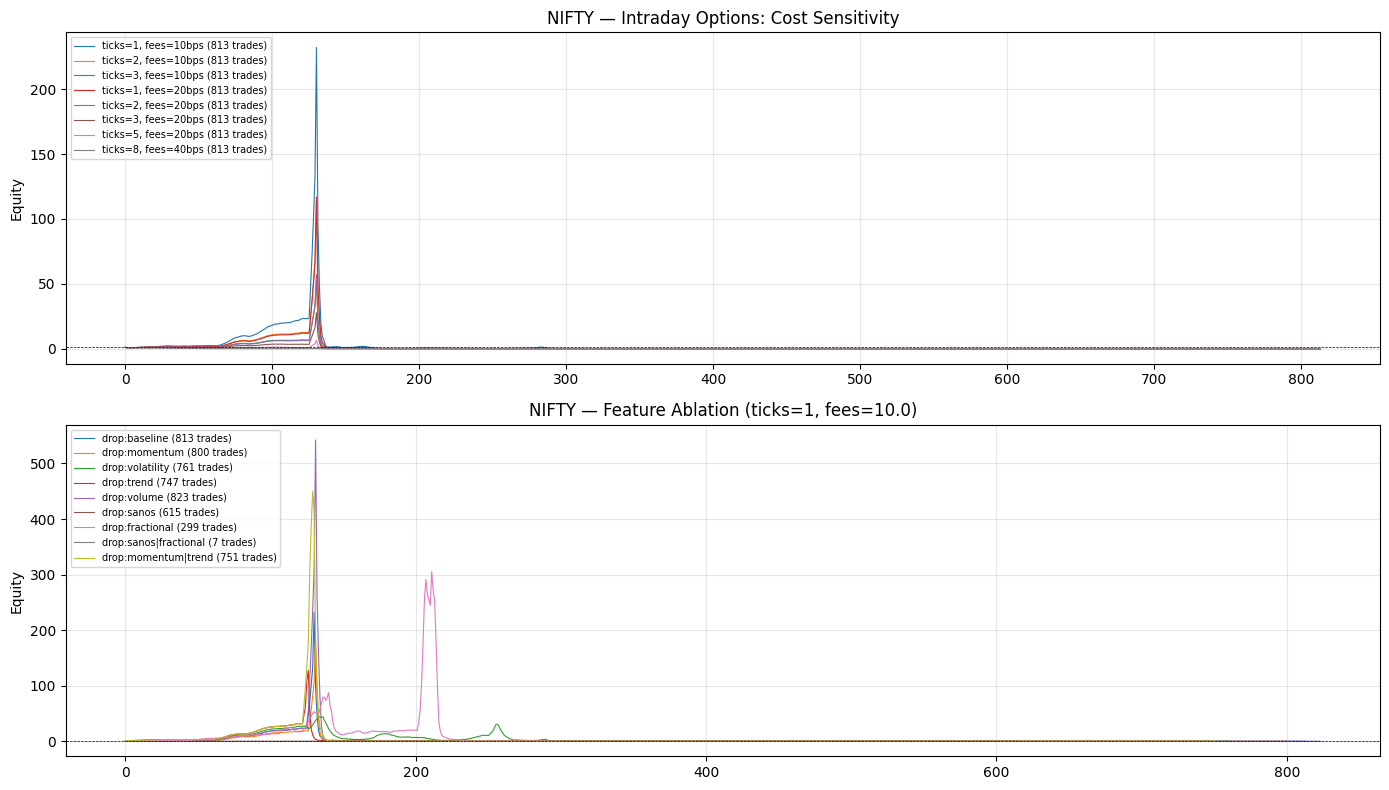

In [15]:
"""Cell 14: Equity curve visualization."""
import matplotlib.pyplot as plt

# Plot equity curves for baseline ablation across cost scenarios
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

ax = axes[0]
for (spread_ticks, fees_bps, drop_groups), v in results.items():
    if drop_groups != tuple():
        continue
    tdf = v["trades_df"]
    if tdf.empty:
        continue
    eq = equity_curve_from_returns(tdf["r"].values)
    label = f"ticks={spread_ticks}, fees={fees_bps:.0f}bps ({v['trades']} trades)"
    ax.plot(eq, linewidth=0.8, label=label)

ax.legend(fontsize=7, loc="upper left")
ax.set_ylabel("Equity")
ax.set_title(f"{NAME} — Intraday Options: Cost Sensitivity")
ax.axhline(1.0, color="black", linewidth=0.5, linestyle="--")
ax.grid(alpha=0.3)

# Ablation comparison at reference cost
ax = axes[1]
ref_cost = None
for k in results.keys():
    ref_cost = (k[0], k[1])
    break

if ref_cost:
    for (spread_ticks, fees_bps, drop_groups), v in results.items():
        if (spread_ticks, fees_bps) != ref_cost:
            continue
        tdf = v["trades_df"]
        if tdf.empty:
            continue
        eq = equity_curve_from_returns(tdf["r"].values)
        label = "|".join(drop_groups) if drop_groups else "baseline"
        ax.plot(eq, linewidth=0.8, label=f"drop:{label} ({v['trades']} trades)")

    ax.legend(fontsize=7, loc="upper left")
    ax.set_ylabel("Equity")
    ax.set_title(f"{NAME} — Feature Ablation (ticks={ref_cost[0]}, fees={ref_cost[1]})")
    ax.axhline(1.0, color="black", linewidth=0.5, linestyle="--")
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()